In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Permute
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input, GlobalAveragePooling2D, ReLU, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load cleaned data
loaded = np.load('/content/drive/MyDrive/ML data/mtg_data_balanced.npz', allow_pickle=True, mmap_mode='r')
X_train = loaded['X_train']
Y_train = loaded['Y_train']
X_test = loaded['X_test']
Y_test = loaded['Y_test']

In [ ]:
#save track IDs separately
Y_test_ids = Y_test[:,0]
Y_train_ids = Y_train[:,0]
#convert all to float16
X_train = X_train.astype('float16')
X_test = X_test.astype('float16')
Y_train = Y_train[:, 1:].astype('float16')
Y_test = Y_test[:, 1:].astype('float16')

In [ ]:
#confirm shapes
print(X_train.shape, Y_train.shape)

(11514, 96, 1400, 1) (11514, 10)


In [ ]:
#make generators as to not overwhelm RAM
def train_generator(batch_size=32):
    n = X_train.shape[0]
    while True:
        idx = np.random.permutation(n)
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_idx = idx[start:end]
            yield X_train[batch_idx], Y_train[batch_idx]

def val_generator(batch_size=32):
    n = X_test.shape[0]
    while True:
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_idx = np.arange(start, min(end, n))
            yield X_test[batch_idx], Y_test[batch_idx]

batch_size = 16
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator(batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, *X_train.shape[1:]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *Y_train.shape[1:]), dtype=tf.float32)
    )
)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator(batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, *X_test.shape[1:]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *Y_test.shape[1:]), dtype=tf.float32)
    )
)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
#ACTUAL best model as of sat evening:
model = Sequential([
    Input(shape=(96, 1400, 1)),

    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),  # 96x1400 → 48x700

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(),

    Lambda(lambda t: tf.reduce_mean(t, axis=1)),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),

    Dense(10, activation='softmax')  # adjust for your number of classes
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5, patience=2, min_lr=1e-5, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[callbacks]
)

Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 254s 345ms/step - accuracy: 0.2440 - loss: 3.2705 - val_accuracy: 0.2399 - val_loss: 2.4622 - learning_rate: 0.0010
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 246s 342ms/step - accuracy: 0.2686 - loss: 2.1908 - val_accuracy: 0.2228 - val_loss: 2.2961 - learning_rate: 0.0010
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 246s 342ms/step - accuracy: 0.2870 - loss: 2.1974 - val_accuracy: 0.1475 - val_loss: 2.6259 - learning_rate: 0.0010
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2841 - loss: 2.2064
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
719/719 ━━━━━━━━━━━━━━━━━━━━ 245s 341ms/step - accuracy: 0.2841 - loss: 2.2064 - val_accuracy: 0.2097 - val_loss: 2.3734 - learning_rate: 0.0010
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 246s 342ms/step - accuracy: 0.3170 - loss: 2.0690 - val_accuracy: 0.2806 - val_loss: 2.1798 - learning_rate: 5.0000e-04
Epoch 6/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 262s 364ms/step - accur

In [ ]:
#plot confusion matrix of results
y_test_pred = model.predict(X_test)
test_predicted = np.argmax(y_test_pred, axis=1)
test_true = np.argmax(Y_test, axis=1)

genres = ['ambient_chill',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

cm = confusion_matrix(test_true, test_predicted)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=45)
plt.yticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=0)
plt.title('Confusion Matrix for Music Genre Classification')

NameError: name 'model' is not defined

In [ ]:
model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=3,  # number of new epochs
)

Epoch 1/3
719/719 ━━━━━━━━━━━━━━━━━━━━ 247s 344ms/step - accuracy: 0.4307 - loss: 1.6146 - val_accuracy: 0.4120 - val_loss: 1.6921
Epoch 2/3
719/719 ━━━━━━━━━━━━━━━━━━━━ 247s 343ms/step - accuracy: 0.4503 - loss: 1.5735 - val_accuracy: 0.4177 - val_loss: 1.7342
Epoch 3/3
719/719 ━━━━━━━━━━━━━━━━━━━━ 247s 343ms/step - accuracy: 0.4501 - loss: 1.5352 - val_accuracy: 0.3898 - val_loss: 1.7873


In [ ]:
#model that did pretty good but didn't finish
model = Sequential([
    Input(shape=(96, 1400, 1)),

    # --- Conv block 1 ---
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_regularizer=keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2,2)),  # (96,1400) → (48,700)

    # --- Conv block 2 ---
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_regularizer=keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2,2)),  # (48,700) → (24,350)

    # --- Conv block 3 ---
    Conv2D(256, (3,3), activation='relu', padding='same',
           kernel_regularizer=keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2,2)),  # (24,350) → (12,175)

    # --- Final Conv to reduce channels ---
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_regularizer=keras.regularizers.l2(1e-4)),
    BatchNormalization(),

    # --- Rearrange to (timesteps, features) for LSTM ---
    Permute((2, 1, 3)),         # (12,175,128) → (175,12,128)
    Reshape((175, 12 * 128)),   # → (175, 1536)

    # --- Recurrent stack ---
    Bidirectional(LSTM(128, return_sequences=True,
                       dropout=0.2, recurrent_dropout=0.1)),
    Bidirectional(LSTM(64, return_sequences=False,
                       dropout=0.2, recurrent_dropout=0.1)),

    Dropout(0.3),

    Dense(10, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/20
  4/719 ━━━━━━━━━━━━━━━━━━━━ 26:12 2s/step - accuracy: 0.1237 - loss: 2.3558

KeyboardInterrupt: 

In [ ]:
#deeper pure CNN
model = Sequential([
    Input(shape=(96, 1400, 1)),

    Conv2D(32, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 96 x 1400 x 32
    Conv2D(32, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 96 x 1400 x 32
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    #output of 48 x 700 x 32

    Conv2D(64, (5,5), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 48 x 700 x 64
    Conv2D(64, (5,5), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 48 x 700 x 64
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    #output of 24 x 350 x 64

    Conv2D(128, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 24 x 350 x 128
    Conv2D(128, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 24 x 350 x 128
    MaxPooling2D(pool_size=(3,3)),
    Dropout(0.3),
    #output of 8 x 116 x 128

    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 8 x 116 x 256
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    ReLU(),
    #output of 8 x 116 x 256
    GlobalAveragePooling2D(),
    Dropout(0.4),
    #output of 256

    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(10, activation="softmax")
])


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 240s 284ms/step - accuracy: 0.1957 - loss: 2.1854 - val_accuracy: 0.2295 - val_loss: 2.0690
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 225s 282ms/step - accuracy: 0.2918 - loss: 1.9269 - val_accuracy: 0.3118 - val_loss: 1.9275
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 201s 279ms/step - accuracy: 0.3367 - loss: 1.8436 - val_accuracy: 0.2970 - val_loss: 2.0272
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 201s 279ms/step - accuracy: 0.3744 - loss: 1.7425 - val_accuracy: 0.3360 - val_loss: 1.9587


In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 202s 280ms/step - accuracy: 0.3923 - loss: 1.7085 - val_accuracy: 0.3253 - val_loss: 1.8941
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 202s 280ms/step - accuracy: 0.4134 - loss: 1.6569 - val_accuracy: 0.3468 - val_loss: 1.9256
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 201s 280ms/step - accuracy: 0.4330 - loss: 1.6091 - val_accuracy: 0.3925 - val_loss: 1.8048
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 201s 279ms/step - accuracy: 0.4337 - loss: 1.6071 - val_accuracy: 0.3767 - val_loss: 1.9139
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 201s 279ms/step - accuracy: 0.4431 - loss: 1.5768 - val_accuracy: 0.2544 - val_loss: 2.2610


In [ ]:
#plot confusion matrix of results
y_test_pred = model.predict(X_test)
test_predicted = np.argmax(y_test_pred, axis=1)
test_true = np.argmax(Y_test, axis=1)

genres = ['ambient_chill',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

cm = confusion_matrix(test_true, test_predicted)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=45)
plt.yticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=0)
plt.title('Confusion Matrix for Music Genre Classification')

94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step


NameError: name 'y_test' is not defined

Text(0.5, 1.0, 'Confusion Matrix for Music Genre Classification')

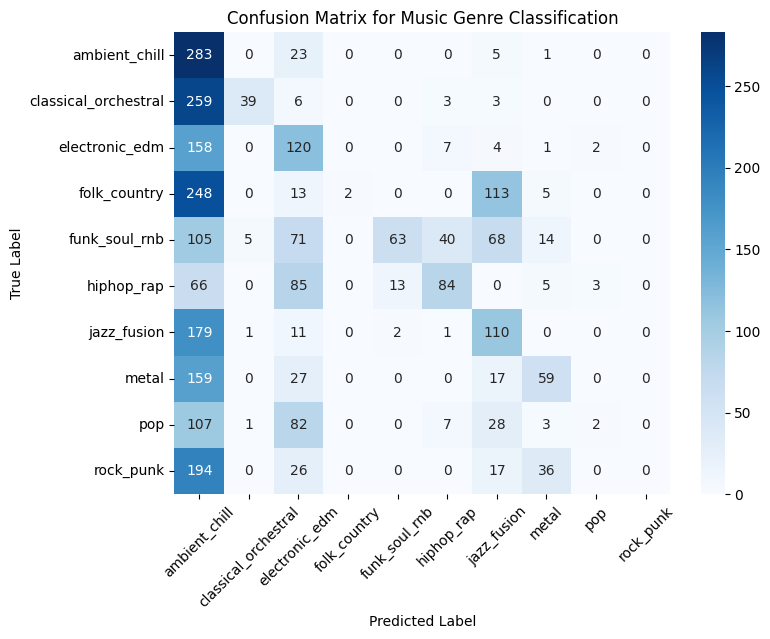

In [ ]:
y_test_pred = model.predict(X_test)
test_predicted = np.argmax(y_test_pred, axis=1)
test_true = np.argmax(Y_test, axis=1)

genres = ['ambient_chill',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

cm = confusion_matrix(test_true, test_predicted)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=45)
plt.yticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=0)
plt.title('Confusion Matrix for Music Genre Classification')